# **Kings County House Price Prediction Project**



## **1.0 Business Overview**

This aim of this project is to utilize linear regression techiques to predict final house sale prices in King County in Washington State. This includes major cities such as Seattle and Redmond. The project is from the perspective of being hypothetically commissioned by a local realty company in Seattle to produce a model to accurately predict sale prices. The company will then use these results to more judiciously consider what clients it takes on as well as to appropriately set fees, rates, commissions, and the like.

### **1.1 Project Details**

For this project we'll be producing both 2 types of regression models.
- ***Inferential***: where we aim to understand how altering a feature affects the overall house price.
- ***Predictive***: where we simply aim to predict the house price as accurately as possible.

Our methodology for building models will will vary for each of these tasks.

### **1.2 Data**

- We utilized a dataset from the King County Assessor's public website, which lists house sale prices and other data for over 21,000 houses in the period from May 2014 - May 2015.

- We also manually scraped data from UnitedStatesZipCodes.org for a number of additional datapoints and features.

## **2.0 EDA**

### **2.1 Import initial libraries**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
df = pd.read_csv('drive/MyDrive/DS_Projects/kc_house_project/data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


### **2.2 Data Cleaning**

We should check to see if the datastypes for each column makes sense as well as check for **missing values**.

In [3]:
# Checking for datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

***Quick Summary***
- The **ID** column can be dropped so can date as we are not doing time series analysis.
- We can also change **yr_renovated** to int64

In [4]:
df = df.drop(['id', 'date'], axis = 1)

In [5]:
# Checking for na values
na_dict = dict(df.isna().sum())

na_list = []
for key, value in na_dict.items():
  if value > 0:
    na_list.append({'name': key, 'na_values': value})

# we see that these 3 columns have many missing values
na_list

[{'na_values': 2376, 'name': 'waterfront'},
 {'na_values': 63, 'name': 'view'},
 {'na_values': 3842, 'name': 'yr_renovated'}]

Let's look more into the missing values.

In [6]:
# investigating 'yr_renovated'
df['yr_renovated'].value_counts()

0.0       17011
2014.0       73
2013.0       31
2003.0       31
2007.0       30
          ...  
1951.0        1
1953.0        1
1946.0        1
1976.0        1
1948.0        1
Name: yr_renovated, Length: 70, dtype: int64

We can see there are over 17,000 **0.0** values for year renovated. These represent houses that have not been renovated.

Rather than specifying the year, we can alter the column to simply be **0.0** if the house has not been renovated or 1.0 if it has been renovated.

In [7]:
df['yr_renovated'] = df['yr_renovated'].apply(lambda x: 1 if x != 0 else 0)
df['yr_renovated'].value_counts()

0    17011
1     4586
Name: yr_renovated, dtype: int64

In [8]:
# investigating 'waterfront'
df['waterfront'].value_counts()

NO     19075
YES      146
Name: waterfront, dtype: int64

Here, there is a very large imbalance between NO and YES. Setting the missing values to NO is the safest bet. <br>
We will do this after doing train-test-split

In [9]:
# investigating 'view'
df['view'].value_counts()

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

Again, we can set the 63 missing values to the modal class, 'NONE'.<br>
Again, we will do this after train test split.

### **2.3 Examining Distributions**

This is most important when considering the assumptions for linear regression and identifying outliers.

In [10]:
# Pairplot
#sns.pairplot(data = df)

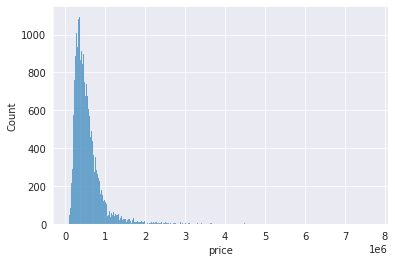

In [11]:
sns.histplot(data = df, x = 'price');

When we look at the graph above, we can see that the distribution is largely contained between 0 to 2,000,000. The graph exapands all the way out because of **outliers** <br>
Let's take a closer look at them.

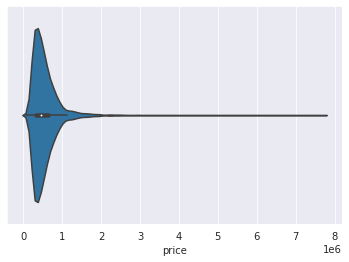

In [12]:
sns.violinplot(data = df, x = 'price');

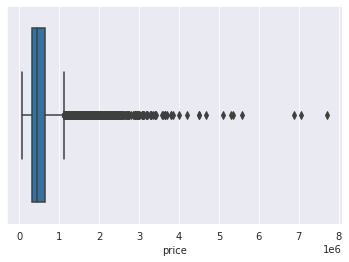

In [13]:
sns.boxplot(data = df, x = 'price');

With the violin & box plots, it is clear that we are dealing with outliers beyond 1.1 million USD.<br>
We can visualise the distribution of prices between 1.1m and the max amount.

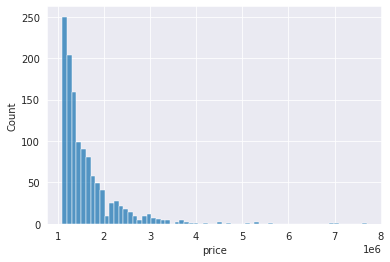

In [14]:
sns.histplot(data = df[(df['price'].between(1100000,9000000))], x = 'price')

It seems there are outliers beyond 4 million.

In [15]:
len(df[df['price'] > 4000000])

11

As there are only 11 values beyond 4 million, we can delete them. <br>
We'll then make 2 separate datasets:
- one for modelling prices up to 1.1m
- the other to model between 1.1m and 4m

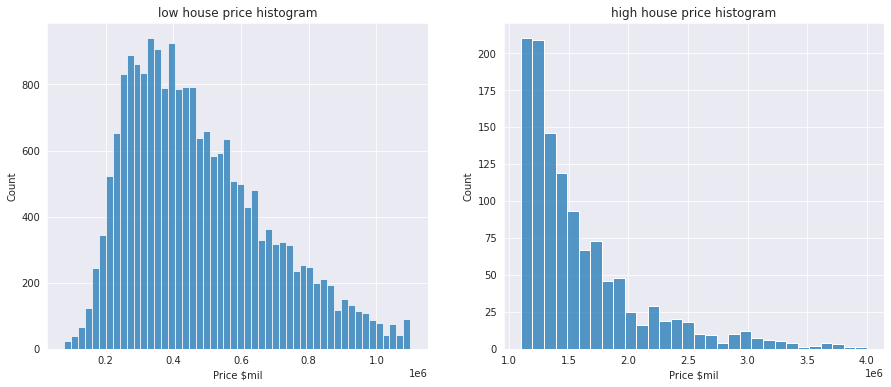

In [21]:
# 1st dataset
low_prices_df = df[df['price'].between(0, 1100000)]

# 2nd dataset
high_prices_df = df[df['price'].between(1100000, 4000000)]

# 1st dataset
f = plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
ax1 = sns.histplot(low_prices_df, x = 'price')
ax1.set_title('low house price histogram')
ax1.set_xlabel('Price $mil');

# 2nd dataset
plt.subplot(1, 2, 2)
ax2 = sns.histplot(high_prices_df, x = 'price')
ax2.set_title('high house price histogram')
ax2.set_xlabel('Price $mil');

**Quick Analysis:** whilst we see that the graph on the left is normally distributed, the prices show a **skewed distribution**. We should keep this in mind when modelling.

## **3.0 Data Preparation**

### **3.1 Feature Engineering**
Now we are at a point where we can do some feature engineering for our dataset. <br>
Firstly, we can do some webscraping to gather some more data specific to each **zipcode**.

### **3.2 Train-test split**

In [22]:
from sklearn.model_selection import train_test_split

In [28]:
# low price set
X1 = low_prices_df.drop('price', axis = 1)
y1 = low_prices_df['price']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1)



In [27]:
y_train1

19493    725000.0
859      166600.0
8580     775000.0
8536     752000.0
3110     850000.0
           ...   
11914    522500.0
2603     300000.0
9466     215000.0
16188    185000.0
14691    315000.0
Name: price, Length: 15309, dtype: float64

In [ ]:
# high price set
X2 = high_prices_df.drop('price', axis = 1)
y2 = high_prices_df['price']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2)